In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/MedicalMCQA-dh22

/content/drive/MyDrive/MedicalMCQA-dh22


##**1. Process paragraph**

In [4]:
# Read data
import os
import pandas as pd

corpus = []
for file_name in os.listdir('./data/corpus'):
    with open(f'./data/corpus/{file_name}', 'r') as f:
        doc = f.readlines()
    corpus.append(" ".join(doc))

test_data = pd.read_csv("./data/public_test.csv")

In [ ]:
# import re
# from tqdm import tqdm

# # corpus[0][-2000:]
# # d = set()
# # for doc in tqdm(corpus):
# #     matches = re.findall(r".{4} Tâm Anh", doc)
# #     for m in matches:
# #         d.add(m)
# #     matches = re.findall(r".{17} Tâm Anh", doc)
# #     for m in matches:
# #         d.add(m)

# # for s in d:
# #     print(s)





# # for idx, doc in enumerate(corpus):
# #     doc = doc [-2000:]
# #     if "với Tâm Anh" in doc:
# #         print(idx)
# #         break

# doc = corpus[76]
# print(doc[-2000:])
# # print(doc)
# print(remove_hospital_ads(doc)[-2000:])

In [113]:
import re
import string

def remove_url(text):
    return re.sub(r"http\S+", "", text)

def remove_poor_information_trunk(text):
    # remove BV TamAnh quote links
    text = re.sub(r"<blockquote>.*?</blockquote>", "", text)

    # remove BV TamAnh advertising portions
    text = remove_hospital_ads(text)
    return text

hospital_token_list = [
    "BVĐK Tâm Anh",
    "BVĐ K Tâm Anh",
    "BV Tâm Anh",
    "tại Tâm Anh",
    "Tại Tâm Anh",
    "Bệnh Viện Tâm Anh",
    "Bệnh Viện Đa Khoa Tâm Anh",
    "với Tâm Anh",
    "IVF Tâm Anh",
]
hospital_re_list = list(map(lambda token: re.compile("{}.*?(  |\.|\n)".format(token[::-1].lower()), re.IGNORECASE), hospital_token_list))
def remove_hospital_ads(doc):
    tail = doc[-2000:][::-1]
    start = 0
    for p in hospital_re_list:
        # res = re.search(p, tail)
        iter = re.finditer(p, tail)
        res = [m.start(1) for m in iter]
        if res:
            # index = res.start(1)
            index = max(res)
            print(res, index)
            if start < index:
                start = index
    return doc[:-start]

def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

codes = ["&#8211", "&#038"]
def remove_special_token(text):
    for code in codes:
        text = text.replace(code, " ")
    return text

def remove_punctation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
    return text

def preprocess_text(text, remove_punc=True, is_lower=True):
    if remove_punc:
        text = " ".join(remove_punctation(remove_special_token(remove_html_tags(remove_poor_information_trunk(remove_url(text))))).split())
    else:
        text = " ".join(remove_special_token(remove_html_tags(remove_poor_information_trunk(remove_url(text)))).split())
    if is_lower:
        return text.lower()
    else:
        return text

In [65]:
# Get title (or title + sub_title (menu))
codes = ["&#8211", "&#038"]
def get_titles(corpus):
    titles = []
    for doc in corpus:
        raw = doc.split("\n")[5]
        title = doc.split("\n")[5].split(":")[0].split("?")[0]
        for code in codes:
            title = title.replace(code, " ")
        title = preprocess_text(title)
        titles.append(title)
    return titles

titles = get_titles(corpus)

In [66]:
def split_doc(doc):
    paragraphs = doc.split("<h3>Mục lục</h3>")[1].split("<h2>")
    menu = paragraphs[0]
    paragraphs = paragraphs[1:]
    process_paragraphs = []
    for paragraph in paragraphs:
        if "hệ thống bệnh viện đa khoa tâm anh" in paragraph.lower():
            process_paragraph = paragraph.lower().split("hệ thống bệnh viện đa khoa tâm anh")[0]
            process_paragraph = paragraph[ : len(process_paragraph)]
        else:
            process_paragraph = paragraph
        process_paragraphs.append(process_paragraph)
    return menu, process_paragraphs

**Test set**

In [114]:
# process_passages = [preprocess_text(passage, False, False) for passage in passages]
# for idx, doc in enumerate(corpus):
#     if "quote" in doc:
#         print(idx)
#         break

doc = corpus[2]
# preprocess_text(doc)
print(doc[-2000:])
print(remove_hospital_ads(doc)[-2000:])


 bệnh viêm phế quản phổi
  cũng như khiến các triệu chứng tăng nặng, nguy cơ gặp biến chứng cao, thời gian phục hồi lâu. Vì thế, nên ngừng hút thuốc lá để tránh nguy cơ mắc 
 viêm phế quản phổi
  và các bệnh hô hấp khác.
  Nên có chế độ sinh hoạt lành mạnh, ăn uống đầy đủ, không bỏ bữa, bổ sung các chất dinh dưỡng cần thiết. Bên cạnh đó, cần nghỉ ngơi nhiều, tránh kiệt sức, hạn chế thức khuya,&#8230; khiến cơ thể bị suy giảm hệ miễn dịch.
  Tiêm phòng cũng có thể giúp <strong>ngăn ngừa viêm phổi</strong>. Vì thế, nên tiêm phòng cúm hàng năm để hạn chế cơ thể bị virus, vi khuẩn tấn công. Cả người lớn và trẻ em đều nên thực hiện tiêm phòng.
 <em>Người mắc bệnh viêm phế quản phổi cần chủ động đeo khẩu trang để tránh lây bệnh</em> Trong trường hợp bị ho kéo dài, ho ra máu, đau ngực, khó thở,&#8230; và nghi ngờ bị 
 viêm phế quản phổi
 , người bệnh có thể trực tiếp đến Khoa Nội hô hấp, Hệ thống Bệnh viện Đa khoa Tâm Anh để được hỗ trợ.
  Với các bác sĩ đầu ngành giàu kinh nghiệm, giỏi chuy

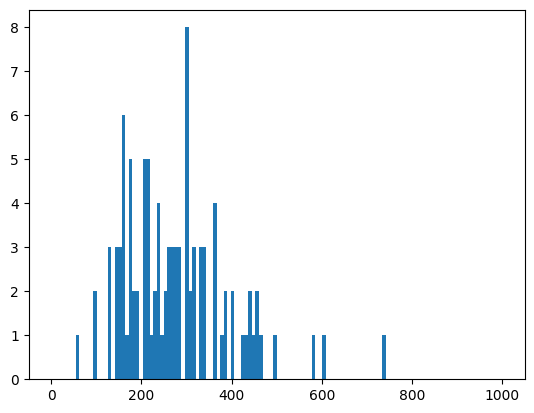

In [ ]:
# import matplotlib.pyplot as plt
# plt.hist([len(doc.split()) for doc in process_passages], bins=128, range=(0, 1000))
# plt.show()

In [ ]:
# test_data.to_csv('./data/public_test_with_context.csv', index=False)

##**2. QA generation by VertexAI**

In [ ]:
!pip install deep_translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.0 MB/s eta 0:00:00


In [ ]:
from deep_translator import GoogleTranslator

translator = GoogleTranslator(source='vi', target='en')

In [ ]:
def translate_text(text):
    if isinstance(text, str):
        translated_text = translator.translate(text)
        return translated_text
    else:
        return ''

In [ ]:
translate_text(test_data['context'][0])

'Method of diagnosing placenta praevia Usually, the diagnosis is made by ultrasound. In addition, ultrasound is also important in diagnosing placenta previa, complications of placenta accreta. (4) Ultrasound images will show that the distance between the placenta and the bladder wall is narrowed, blood vessels passing through the uterine muscle wall to the bladder wall are common on Doppler ultrasound. Therefore, ultrasound is recommended to be performed after the 28th week of pregnancy to detect this complication early. /// How many weeks will it take to know placenta praevia? Doctor Nguyen Duc Hinh said that most cases of placenta previa can be detected as early as the 20th week of pregnancy thanks to fetal ultrasound. During the ultrasound process, with the support of many modern equipment, the doctor can observe where in the uterus the placenta is attached (body, fundus, front, back, left, right). , low grip, semi-central or central). Diagnosis of placenta previa is mainly done by 

In [ ]:
translate_text(test_data['option_5'][0])

''

In [ ]:
from tqdm import tqdm

en_test_data = []
for idx, row in tqdm(test_data.iterrows()):
    id = row['id']
    question = translate_text(row['question'])
    option_1 = translate_text(row['option_1'])
    option_2 = translate_text(row['option_2'])
    option_3 = translate_text(row['option_3'])
    option_4 = translate_text(row['option_4'])
    option_5 = translate_text(row['option_5'])
    option_6 = translate_text(row['option_6'])
    context = translate_text(row['context'])
    data = {
        'id': id,
        'question': question,
        'option_1': option_1,
        'option_2': option_2,
        'option_3': option_3,
        'option_4': option_4,
        'option_5': option_5,
        'option_6': option_6,
        'context': context,
    }
    en_test_data.append(data)

100it [07:27,  4.48s/it]


In [ ]:
en_test_df = pd.DataFrame(en_test_data)

In [ ]:
en_test_df

,id,question,option_1,option_2,option_3,option_4,option_5,option_6,context
0,level3_1,Huong is pregnant and worried she may have pla...,A. Week 10,B.Week 20,C. Week 30,D. Week 40,,,"Method of diagnosing placenta praevia Usually,..."
1,level3_2,Huong is 5 weeks pregnant and is worried she m...,A. 5 weeks,B. 15 weeks,C. 25 weeks,D. 35 weeks,,,"Method of diagnosing placenta praevia Usually,..."
2,level3_5,"How many strikers know that in football, each ...",A. 2,B.3,C. 4,D. 5,,,"Method of diagnosing placenta praevia Usually,..."
3,level3_13,Patient Dung was diagnosed with hepatitis last...,Have,Are not,,,,,Causes of mumps Mumps is present worldwide and...
4,level3_14,A patient has testicular pain. After being que...,A. Urinary tract infection,B. Testicular cancer,C. Trauma,D. Varicocele,,,How dangerous is right testicle pain? Most cas...
...,...,...,...,...,...,...,...,...,...
95,level4_4,Xiao Tang is a famous female singer in China. ...,Sore throat due to tonsillitis,Diabetes,Nasopharyngeal cancer,Internal hemorrhoids,,,What is diabetic retinopathy? Diabetic retinop...
96,level4_9,Mai is currently 9 months pregnant. There are ...,Genital herpes,Gonorrhea,Chlamydia,Syphilis,,,Method for diagnosing morning sickness. Doctor...
97,level4_27,Mr. Bien is 73 years old this year. During a f...,Brain tumors,Lack of brain,Cerebral vascular occlusion,Stroke,,,What is hearing loss in one ear? Unilateral he...
98,level4_28,Brain tumor is a condition in which tumors for...,These are all dangerous diseases,It's all cancer,The exact cause cannot be determined,Occurs most often in the elderly,,,What is a benign brain tumor? A benign brain t...


In [ ]:
en_test_df.to_csv('./data/public_test_with_context_en.csv', index=False)